In [2]:
from diff_predictor import data_process, predxgboost, spatial
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from sklearn.preprocessing import scale, StandardScaler
from robust_pca import r_pca


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

from diff_classifier.features import alpha_calc, unmask_track
from diff_predictor.utils import plot_msd_comparisons, plot_individual_msds, plot_particles_in_frame

import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy.ma as ma

Using current directory for loading/saving: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
To change current directory, call diff_predictor.core.change_dir(...)


In [3]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [4]:
#load paths to data

age_feature_path = workbookDir + '/data/raw_data_age/'
age_feature_filelist = [f for f in listdir(age_feature_path) if isfile(join(age_feature_path, f)) and 'feat' in f]
print(len(age_feature_filelist))

age_msd_path = workbookDir + '/raw_data_age/'
age_msd_filelist = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd' in f]
print(len(age_msd_filelist))

region_dataset_path = workbookDir + '/data/region_feature_folder/'
region_filelist = [f for f in listdir(region_dataset_path) if isfile(join(region_dataset_path, f)) and 'feat' in f]
print(len(region_filelist))

treatment_dataset_path = workbookDir + '/data/ecm_feature_folder/'
treatment_filelist = [f for f in listdir(treatment_dataset_path) if isfile(join(treatment_dataset_path, f)) and 'msd' in f]
print(len(treatment_filelist))

75
74
38
180


# Analysis of age dataset

In [123]:
fstats_tot_age = data_process.generate_fullstats(age_feature_path, age_feature_filelist, ['P14','P35', 'P70'], 'age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P35_brain_2_slice_1_vid_4.csv size: (878, 91)
Adding file features_P35_brain_2_slice_1_vid_5.csv size: (467, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P35_brain_2_slice_1_vid_2.csv size: (833, 91)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P35_brain_2_slice_1_vid_3.csv size: (1017, 91)
A

In [7]:
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [126]:
ecm = fstats_tot_age[features + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [36]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900


In [37]:
label_df = bal_ecm[target]
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

In [38]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [39]:
spatial.get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 14700
Training: 7188 (0.489%)
Testing: 3756 (0.256%)
Evaluation: 3756 (0.256%)


In [8]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [14]:
(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(X_train=X_train, y_train=X_train['encoded_target'], features=features, init_params=param)

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [139]:
best_param = {'max_depth': 4, 'eta': 0.1, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}

In [41]:
# Currently using parameters found in the diff_mode analysis notebook for age
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=96, verbose=False)


Accuracy: 0.8445154419595314


In [42]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.8755    0.8863    0.8808      1222
         P35     0.7817    0.7598    0.7706      1249
         P70     0.8736    0.8872    0.8803      1285

    accuracy                         0.8445      3756
   macro avg     0.8436    0.8444    0.8439      3756
weighted avg     0.8437    0.8445    0.8440      3756



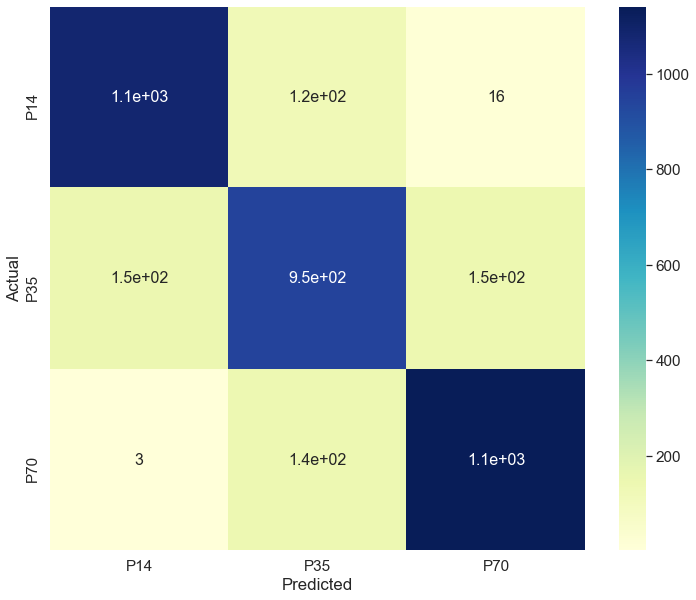

In [43]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [44]:
# Needed bc of this issue: https://github.com/slundberg/shap/issues/1215

# model_bytearray = booster.save_raw()[4:]
# def myfun(self=None):
#     return model_bytearray

# booster.save_raw = myfun

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])

In [45]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

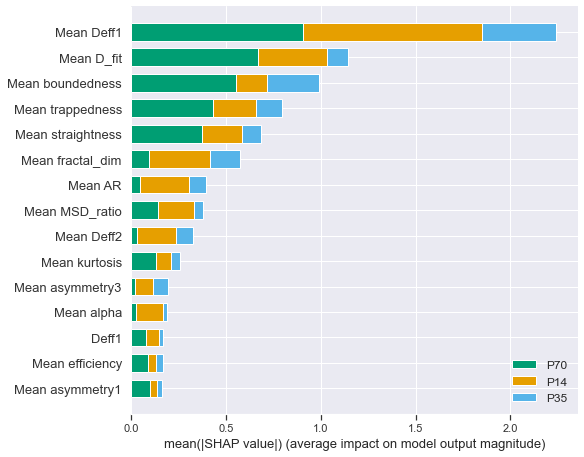

In [46]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

### Outlier detection

In [97]:
scaler = StandardScaler()
features_df_filled = ecm[features].fillna(0)
scaled_df = scaler.fit_transform(features_df_filled)
scaled_df = pd.DataFrame(scaled_df, columns=features)

In [98]:
features_df_filled

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean AR,Mean elongation,Mean boundedness,Mean fractal_dim,Mean trappedness,Mean efficiency,Mean straightness,Mean MSD_ratio,Mean Deff1,Mean Deff2
0,0.300022,1.466714,1.827982,0.831748,0.214532,0.234618,1.377828,0.274220,0.208504,2.180911,...,2.558671,0.500849,0.077719,1.778684,-0.203714,0.522740,0.146740,0.478852,1.910137,1.054939
1,0.320179,34.234700,1.986628,0.871043,0.185748,0.268897,1.844000,0.457701,0.169997,2.007813,...,2.790575,0.566797,0.062083,1.738185,-0.208361,0.518803,0.126079,1.023370,4.419614,0.879117
2,1.724717,0.283085,3.071816,0.997034,0.027251,0.594843,5.022024,0.800877,0.032339,1.367141,...,2.951955,0.588361,0.068945,1.668717,-0.206330,1.116364,0.223336,0.624219,5.257431,0.000000
3,4.628234,0.000021,1.718922,0.786380,0.244962,0.203225,2.448351,0.591562,0.063546,1.763388,...,2.951955,0.588361,0.068945,1.668717,-0.206330,1.116364,0.223336,0.624219,5.257431,0.000000
4,1.447265,0.054312,2.213652,0.999969,0.002783,0.682137,15.441644,0.935240,0.015247,1.908143,...,18.341212,0.942667,0.028242,1.711037,-0.218619,0.357306,0.090795,0.330886,1.253643,1.082479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38782,0.186162,5.578552,2.708435,0.826497,0.218183,0.230605,1.766589,0.433937,0.151994,2.158246,...,2.291360,0.479017,0.093735,2.026852,-0.198831,0.193313,0.093485,0.657813,1.003318,0.068079
38784,1.205907,4.350913,3.221466,0.975484,0.078773,0.453535,2.644417,0.621845,0.062851,1.402521,...,2.397721,0.517960,0.114610,1.660474,-0.192703,0.696942,0.236684,0.671486,9.239511,0.000000
38785,1.244407,3.097007,3.828334,0.190884,0.626005,0.026808,1.131339,0.116092,0.151173,1.747224,...,2.255818,0.483463,0.087333,1.642152,-0.200793,0.798416,0.215354,0.352881,13.974769,13.625148
38786,0.856812,38.059204,2.305006,0.243213,0.582611,0.035397,1.043384,0.041580,0.097239,1.515172,...,2.072744,0.439809,0.104316,1.690506,-0.195747,0.793246,0.248056,0.189751,13.410963,1.447776


In [99]:
L, S = r_pca.R_pca(scaled_df).fit(max_iter=5000)

iteration: 1, error: 0.33742470791242857
iteration: 100, error: 0.001421840460143009
iteration: 200, error: 0.0013442431841444197
iteration: 300, error: 0.001215150157510675
iteration: 400, error: 0.0012335808700662872
iteration: 500, error: 0.0013130438417539698
iteration: 600, error: 0.0010457216617579263
iteration: 700, error: 0.0009347528430520776
iteration: 800, error: 0.0008423601595553127
iteration: 900, error: 0.001320473470684468
iteration: 1000, error: 0.0011761343495920312
iteration: 1100, error: 0.0010545241944393147
iteration: 1200, error: 0.0010628053284969497
iteration: 1300, error: 0.0010749386138158617
iteration: 1400, error: 0.0011235594104969397
iteration: 1500, error: 0.0012754471686809705
iteration: 1600, error: 0.001805255420123608
iteration: 1700, error: 0.0014422658761289813
iteration: 1800, error: 0.005292204487216265
iteration: 1900, error: 0.002065234913357426
iteration: 2000, error: 0.002184229327285333
iteration: 2100, error: 0.006379436826808724
iteration:

In [100]:
S_array = np.absolute(S.values)
S_array

S_magnitudes = np.zeros(len(S))
for i in range(len(S)):
    abs_sum = np.sum(S_array[i])
    S_magnitudes[i] = abs_sum

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  1.15212212,   1.17426878,   1.19641545, ..., 111.84114911,
        111.86329577, 111.88544243]),
 <BarContainer object of 5000 artists>)

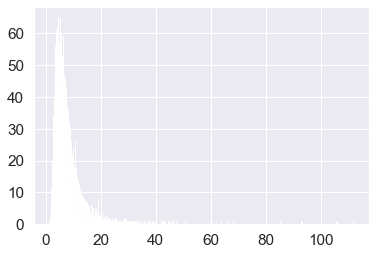

In [65]:
plt.hist(S_magnitudes, bins=5000)

Text(0.5, 1.0, 'Distrubution of Sparse Matrix Magnitudes')

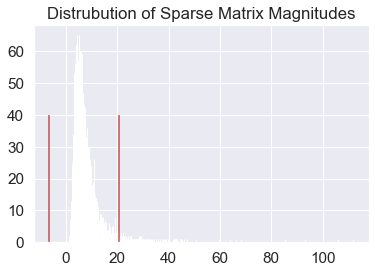

In [66]:
plt.hist((S_magnitudes), bins=5000)
plt.vlines((S_magnitudes).mean()+((S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.vlines((S_magnitudes).mean()-((S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.title('Distrubution of Sparse Matrix Magnitudes')

Text(0.5, 1.0, 'Distrubution of Sparse Matrix Magnitudes')

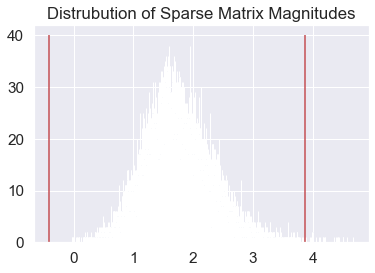

In [184]:
plt.hist(np.log(S_magnitudes), bins=5000)
plt.vlines(np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*4), ymin=0, ymax=40, color='r')
plt.vlines(np.log(S_magnitudes).mean()-(np.log(S_magnitudes).std()*4), ymin=0, ymax=40, color='r')
plt.title('Distrubution of Sparse Matrix Magnitudes')

In [200]:
upper_outlier_cutoff = np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*5)
S_mag_log = np.log(S_magnitudes)
outliers = S_mag_log[S_mag_log > upper_outlier_cutoff]
print(len(outliers))
outlier_inds = np.where(S_mag_log > upper_outlier_cutoff)
normal_inds = np.where(S_mag_log <= upper_outlier_cutoff)
outlier_inds[0]
outlier_df = ecm.iloc[outlier_inds[0]]
normal_df = ecm.iloc[normal_inds[0]]

9

In [203]:
bal_ecm = data_process.balance_data(normal_df, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (P70:P14:P35) = 13964:4900:14864
Ratio after balance (P70:P14:P35) = 4900:4900:4900


In [204]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [205]:
# Currently using parameters found in the diff_mode analysis notebook for age
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=96, verbose=False)


Accuracy: 0.8620782003213712


In [206]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.9035    0.8753    0.8892      1187
         P35     0.8133    0.7836    0.7982      1229
         P70     0.8693    0.9234    0.8955      1318

    accuracy                         0.8621      3734
   macro avg     0.8620    0.8607    0.8610      3734
weighted avg     0.8617    0.8621    0.8615      3734



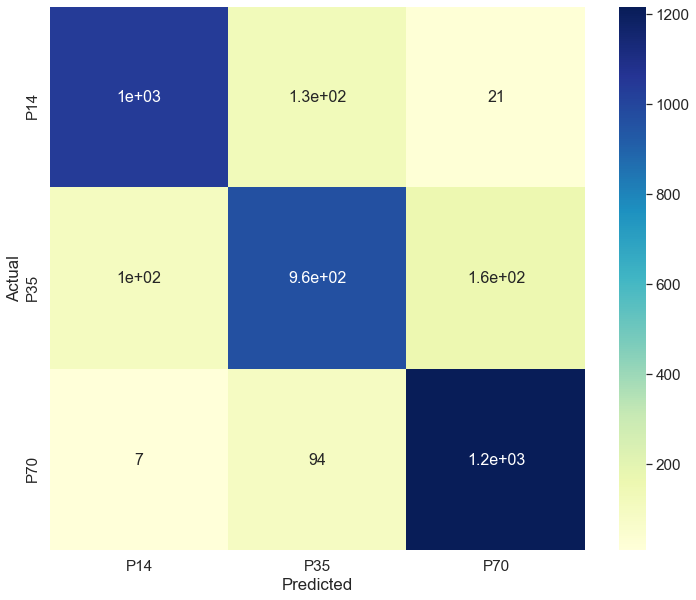

In [207]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

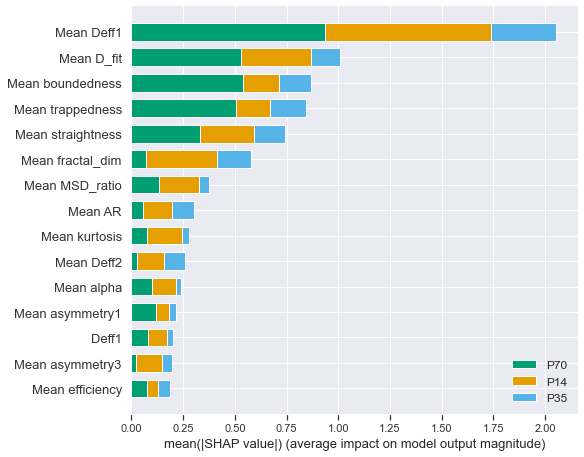

In [208]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

In [209]:
le = preprocessing.LabelEncoder()
outlier_df['encoded_target'] = le.fit_transform(outlier_df[target])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [210]:

y_outlier = outlier_df['encoded_target']
d_outliers = xgb.DMatrix(outlier_df[features], label=y_outlier)

In [211]:
true_label = d_outliers.get_label()
ypred = booster.predict(d_outliers)
preds = [np.where(x == np.max(x))[0][0] for x in ypred]
acc = accuracy_score(true_label, preds)
print("Accuracy:",acc)

Accuracy: 0.0


In [215]:
preds
true_label

array([1., 1., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [212]:
class_names = le.classes_
class_results = classification_report(y_outlier, preds, digits=4, target_names = class_names)
print(str(class_results))

ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

In [213]:
metrics.confusion_matrix(y_outlier, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_outlier, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

ValueError: Shape of passed values is (3, 3), indices imply (2, 2)

<Figure size 864x720 with 0 Axes>

IndexError: index 2 is out of bounds for axis 0 with size 2

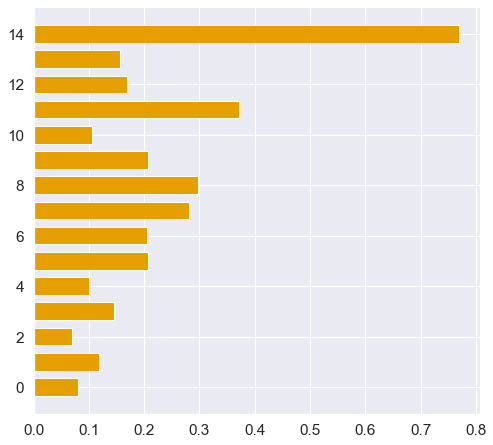

In [216]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(outlier_df[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, outlier_df[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

In [219]:
perr_alph = []
perr_dcoef = []

for i in range(len(age_msd_filelist)):

    
    msd_df = pd.read_csv(age_msd_path + age_msd_filelist[i])
    trackids = msd_df['Track_ID'].unique()
    partcount = trackids.shape[0]
    for particle in range(0, partcount):

        single_track_masked = msd_df.loc[msd_df['Track_ID'] == trackids[particle]].sort_values(['Track_ID', 'Frame'], ascending=[1,1]).reset_index(drop=True)
        single_track = unmask_track(single_track_masked)
        xpos = single_track['MSDs']
        ypos = single_track['Frame']

        def msd_alpha(xpos, alph, dcoef):
                return 4*dcoef*(xpos**alph)

        try:
            popt, pcov = curve_fit(msd_alpha, xpos, ypos)
            alph = popt[0]
            dcoef = popt[1]
            perr = np.sqrt(np.diag(pcov))
            perr_alph.append(perr[0])
            perr_dcoef.append(perr[1])
        except RuntimeError:
            print('Optimal parameters not found. Print NaN instead.')
            alph = np.nan
            dcoef = np.nan
        

Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
invalid value encountered in sqrt
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters c

In [231]:
perr_alph_arr.min()

nan

invalid value encountered in greater_equal
invalid value encountered in less_equal


(array([6.5957e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.34315942e-04, 9.62092885e+05, 1.92418577e+06, 2.88627865e+06,
        3.84837154e+06, 4.81046442e+06, 5.77255731e+06, 6.73465019e+06,
        7.69674307e+06, 8.65883596e+06, 9.62092884e+06]),
 <BarContainer object of 10 artists>)

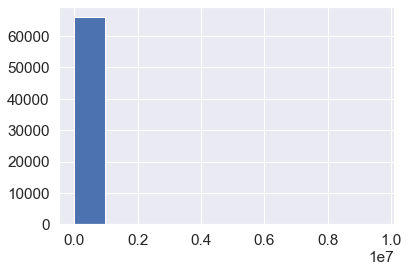

In [230]:
perr_alph_arr = np.array(perr_alph)
perr_alph_arr = perr_alph_arr[perr_alph_arr != np.inf]
perr_alph_arr = perr_alph_arr[perr_alph_arr != np.nan]

plt.hist(perr_alph_arr)

(array([6.5957e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([7.55166985e-09, 3.38748841e+06, 6.77497683e+06, 1.01624652e+07,
        1.35499537e+07, 1.69374421e+07, 2.03249305e+07, 2.37124189e+07,
        2.70999073e+07, 3.04873957e+07, 3.38748841e+07]),
 <BarContainer object of 10 artists>)

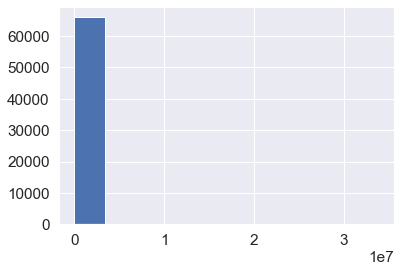

In [221]:
perr_dcoef_arr = np.array(perr_dcoef)
perr_dcoef_arr = perr_dcoef_arr[perr_dcoef_arr != np.inf]
plt.hist(perr_dcoef_arr)

# Region data

In [5]:
fstats_tot_region = data_process.generate_fullstats(region_dataset_path, region_filelist, ['cortex', 'hippocampus', 'striatum', 'ganglia', 'thalamus'], 'region')

Adding file feat_NT_slice_2_striatum_vid_4.csv size: (10237, 67)
Adding file feat_NT_slice_2_striatum_vid_5.csv size: (13938, 67)
Adding file feat_NT_slice_1_striatum_vid_1.csv size: (2431, 67)
Adding file feat_NT_slice_2_cortex_vid_4.csv size: (1429, 67)
Adding file feat_NT_slice_1_striatum_vid_3.csv size: (1536, 67)
Adding file feat_NT_slice_1_cortex_vid_10.csv size: (4832, 67)
Adding file feat_NT_slice_1_striatum_vid_2.csv size: (2240, 67)
Adding file feat_NT_slice_2_cortex_vid_5.csv size: (2210, 67)
Adding file feat_NT_slice_2_cortex_vid_1.csv size: (1388, 67)
Adding file feat_NT_slice_2_hippocampus_vid_2.csv size: (46, 67)
Adding file feat_NT_slice_2_striatum_vid_2.csv size: (10500, 67)
Adding file feat_NT_slice_2_striatum_vid_3.csv size: (11355, 67)
Adding file feat_NT_slice_2_hippocampus_vid_3.csv size: (307, 67)
Adding file feat_NT_slice_2_cortex_vid_2.csv size: (1784, 67)
Adding file feat_NT_slice_1_cortex_vid_8.csv size: (1984, 67)
Adding file feat_NT_slice_1_striatum_vid_5.c

In [9]:
target = 'region'
ecm = fstats_tot_region[features + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(125416, 36)


(96085, 36)

In [10]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)
bal_ecm = bal_ecm.reset_index(drop=True)

Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 44214:27932:10063:2895:10981
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 2895:2895:2895:2895:2895


In [11]:
label_df = bal_ecm[target].copy()
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

In [13]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(label_df)

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [14]:
best_param = {'max_depth': 4,
 'eta': 0.005,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 5,
 'silent': 'True',
 'gamma': 5,
 'subsample': 0.6,
 'colsample_bytree': 0.7,
 'eval_metric': 'mlogloss'}

In [15]:
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=1157, verbose=False)

Accuracy: 0.5956121343445288


In [16]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

      cortex     0.7740    0.8363    0.8039       733
     ganglia     0.5888    0.3526    0.4411       743
 hippocampus     0.4620    0.5211    0.4898       735
    striatum     0.7744    0.8241    0.7985       762
    thalamus     0.3840    0.4353    0.4081       719

    accuracy                         0.5956      3692
   macro avg     0.5966    0.5939    0.5883      3692
weighted avg     0.5987    0.5956    0.5902      3692



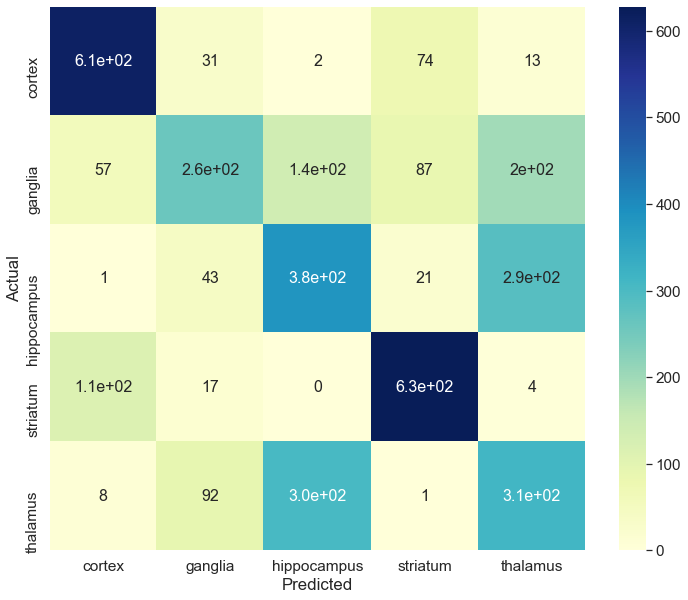

In [17]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

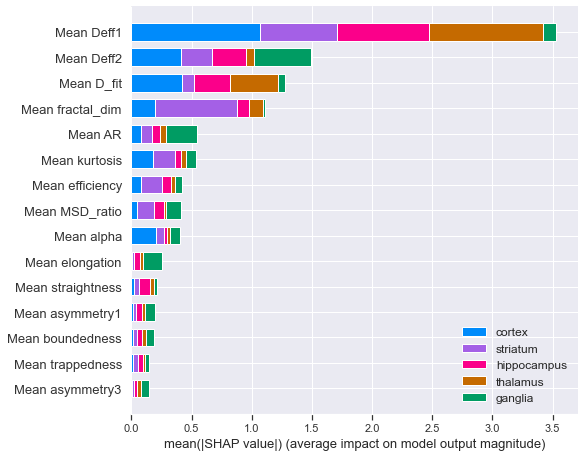

In [19]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
# c_NT = '#E69F00'
# c_HYase = '#56B4E9'
# c_ChABC = '#009E73'

#colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
#cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values')


## Outlier detection

In [20]:
scaler = StandardScaler()
features_df_filled = ecm[features].fillna(0)
scaled_df = scaler.fit_transform(features_df_filled)
scaled_df = pd.DataFrame(scaled_df, columns=features)

In [21]:
L, S = r_pca.R_pca(scaled_df).fit(max_iter=5000)

iteration: 1, error: 0.341815954792675
iteration: 100, error: 0.0015104581544473578
iteration: 200, error: 0.0010065056285318832
iteration: 300, error: 0.0009864726351988895
iteration: 400, error: 0.0008990254061599131
iteration: 500, error: 0.0009328012937508472
iteration: 600, error: 0.0008049168018722348
iteration: 700, error: 0.0008994187972853075
iteration: 800, error: 0.0009588175398781066
iteration: 900, error: 0.0007708828404798081
iteration: 1000, error: 0.00078697196848131
iteration: 1100, error: 0.0012087246168022555
iteration: 1200, error: 0.001223631051972385
iteration: 1300, error: 0.0010891395540591942
iteration: 1400, error: 0.0010369995079837892
iteration: 1500, error: 0.0010363311620397088
iteration: 1600, error: 0.0008903524793438219
iteration: 1700, error: 0.000829446884180978
iteration: 1800, error: 0.0008683734727941296
iteration: 1900, error: 0.0007765605167678525
iteration: 2000, error: 0.0008548089342241192
iteration: 2100, error: 0.0008553004139532273
iteratio

In [22]:
S_array = np.absolute(S.values)
S_array

S_magnitudes = np.zeros(len(S))
for i in range(len(S)):
    abs_sum = np.sum(S_array[i])
    S_magnitudes[i] = abs_sum

(array([1., 2., 3., ..., 0., 0., 1.]),
 array([  0.49425705,   0.53767127,   0.5810855 , ..., 217.47853322,
        217.52194744, 217.56536166]),
 <BarContainer object of 5000 artists>)

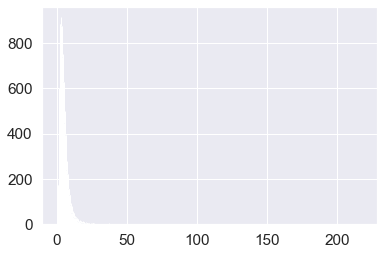

In [24]:
plt.hist(S_magnitudes, bins=5000)

Text(0.5, 1.0, 'Distrubution of Sparse Matrix Magnitudes')

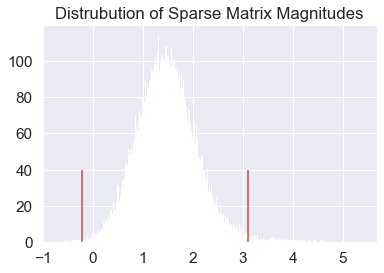

In [26]:
plt.hist(np.log(S_magnitudes), bins=5000)
plt.vlines(np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.vlines(np.log(S_magnitudes).mean()-(np.log(S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.title('Distrubution of Sparse Matrix Magnitudes')

In [28]:
upper_outlier_cutoff = np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*3)
S_mag_log = np.log(S_magnitudes)
outliers = S_mag_log[S_mag_log > upper_outlier_cutoff]
print(len(outliers))
outlier_inds = np.where(S_mag_log > upper_outlier_cutoff)
normal_inds = np.where(S_mag_log <= upper_outlier_cutoff)
outlier_inds[0]
outlier_df = ecm.iloc[outlier_inds[0]]
normal_df = ecm.iloc[normal_inds[0]]

491


In [29]:
bal_ecm = data_process.balance_data(normal_df, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 43985:27844:9994:2855:10916
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 2855:2855:2855:2855:2855


In [30]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)